In [33]:
import numpy as np
import pandas as pd
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [2]:
f = zipfile.ZipFile('./order_products__prior.csv.zip')
order_products = pd.read_csv(f.open('order_products__prior.csv'))

In [3]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [4]:
f1 = zipfile.ZipFile('./orders.csv.zip')
orders = pd.read_csv(f1.open('orders.csv'))

In [5]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
orders = orders[orders['eval_set']=='prior']

In [7]:
df = orders.merge(order_products,on=['order_id'],how='left')

In [8]:
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [9]:
df['days_since_prior_order'].fillna(value=1.0,inplace=True)

In [10]:
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,1.0,196,1,0
1,2539329,1,prior,1,2,8,1.0,14084,2,0
2,2539329,1,prior,1,2,8,1.0,12427,3,0
3,2539329,1,prior,1,2,8,1.0,26088,4,0
4,2539329,1,prior,1,2,8,1.0,26405,5,0


In [11]:
user_features = df.groupby(['user_id']).agg(
    frequency = ('order_id','nunique'),
    recency = ('days_since_prior_order','max')
).reset_index()

In [23]:
user_features.head()

,user_id,frequency,recency
0,1,10,30.0
1,2,14,30.0
2,3,12,21.0
3,4,5,21.0
4,5,4,19.0


/Users/mohdanasqureshi/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


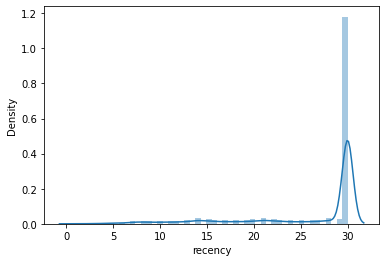

In [12]:
sns.distplot(user_features['recency'],kde=True)
plt.show()

/Users/mohdanasqureshi/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


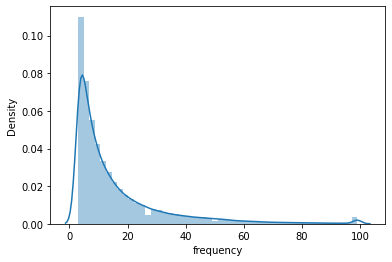

In [13]:
sns.distplot(user_features['frequency'],kde=True)
plt.show()

As we can see the data is skewed, I will use log-transformation to reduce skewness

In [14]:
user_features['recency'] = np.log(user_features['recency'])

In [15]:
user_features['frequency'] = np.log(user_features['frequency'])

In [16]:
user_features.head()

,user_id,frequency,recency
0,1,2.302585,3.401197
1,2,2.639057,3.401197
2,3,2.484907,3.044522
3,4,1.609438,3.044522
4,5,1.386294,2.944439


/Users/mohdanasqureshi/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


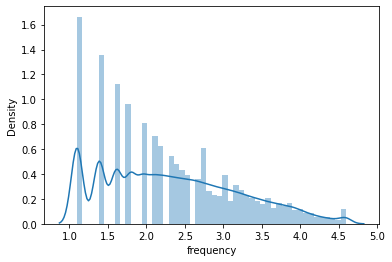

In [17]:
sns.distplot(user_features['frequency'],kde=True)
plt.show()

/Users/mohdanasqureshi/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


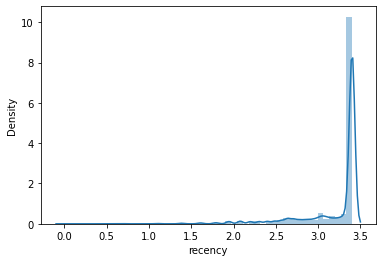

In [18]:
sns.distplot(user_features['recency'],kde=True)
plt.show()

In [19]:
user_features[['frequency','recency']].describe()

,frequency,recency
count,206209.000000,206209.000000
mean,2.331310,3.216358
std,0.880206,0.377494
min,1.098612,0.000000
25%,1.609438,3.218876
50%,2.197225,3.401197
75%,2.944439,3.401197
max,4.595120,3.401197


In [20]:
X = user_features[['recency','frequency']]

In [21]:
X.head()

,recency,frequency
0,3.401197,2.302585
1,3.401197,2.639057
2,3.044522,2.484907
3,3.044522,1.609438
4,2.944439,1.386294


In [24]:
sc = StandardScaler()
sc.fit_transform(X)

array([[ 0.48964963, -0.03263471],
       [ 0.48964963,  0.34963165],
       [-0.4552021 ,  0.17450095],
       ...,
       [ 0.48964963,  0.50133676],
       [-0.58444995,  1.77289659],
       [ 0.48964963,  0.26543753]])

In [25]:
X.describe()

,recency,frequency
count,206209.000000,206209.000000
mean,3.216358,2.331310
std,0.377494,0.880206
min,0.000000,1.098612
25%,3.218876,1.609438
50%,3.401197,2.197225
75%,3.401197,2.944439
max,3.401197,4.595120


Finding optimal clusters

In [28]:
k_cluster = []
k_silht_score = []

for n in range(2,7):
    km = KMeans(n_clusters=n)
    labels = km.fit_predict(X)

    silht_avg = round(silhouette_score(X,labels,random_state=1),3)

    k_cluster.append(n)
    k_silht_score.append(silht_avg)

    print(f'number of clusters {n}-> silhouette score :{silht_avg} ')

number of clusters 2-> silhouette score :0.522 
number of clusters 3-> silhouette score :0.453 
number of clusters 4-> silhouette score :0.488 
number of clusters 5-> silhouette score :0.469 
number of clusters 6-> silhouette score :0.457 


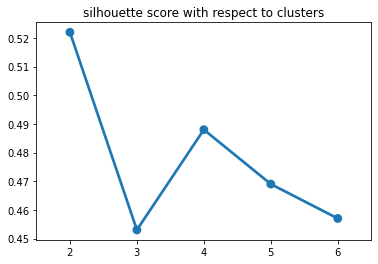

In [29]:
sns.pointplot(x=k_cluster,y=k_silht_score)
plt.title('silhouette score with respect to clusters')
plt.show()

Lower silhouette score implies better formation of clusters. 

In [30]:
km1 = KMeans(n_clusters=3,random_state=1)
km1.fit(X)

cluster_labels = km1.labels_

cl = X.assign(clusters=cluster_labels)

In [32]:
cl.head(10)

,recency,frequency,clusters
0,3.401197,2.302585,0
1,3.401197,2.639057,0
2,3.044522,2.484907,0
3,3.044522,1.609438,2
4,2.944439,1.386294,2
5,2.484907,1.098612,2
6,3.401197,2.995732,1
7,3.401197,1.098612,2
8,3.401197,1.098612,2
9,3.401197,1.609438,2


/Users/mohdanasqureshi/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mohdanasqureshi/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Graph of clusters')

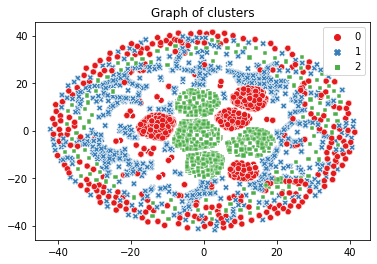

In [34]:
model = TSNE(random_state=1)
transformed = model.fit_transform(X)

sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
plt.title('Graph of clusters')

In [35]:
user_features['cluster'] = cl['clusters']

In [36]:
user_features.head()

,user_id,frequency,recency,cluster
0,1,2.302585,3.401197,0
1,2,2.639057,3.401197,0
2,3,2.484907,3.044522,0
3,4,1.609438,3.044522,2
4,5,1.386294,2.944439,2


In [37]:
df_melt = pd.melt(user_features.reset_index(),id_vars=['user_id','cluster'],value_vars=['frequency','recency'],var_name='Attribute',value_name='Value')

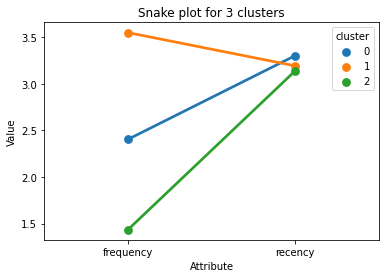

In [40]:
sns.pointplot(x='Attribute',y='Value',hue='cluster',data=df_melt)
plt.title('Snake plot for 3 clusters')
plt.show()

In [41]:
cluster_avg = user_features.groupby(['cluster']).mean()

In [42]:
population_avg = user_features.mean()

In [43]:
relative_importance = cluster_avg/population_avg -1

In [44]:
relative_importance.round(2)

,cluster,frequency,recency,user_id
cluster,,,,
0,NaN,0.03,0.03,0.0
1,NaN,0.52,-0.01,-0.0
2,NaN,-0.38,-0.02,0.0


Text(0.5, 1.0, 'relative importance of attributes')

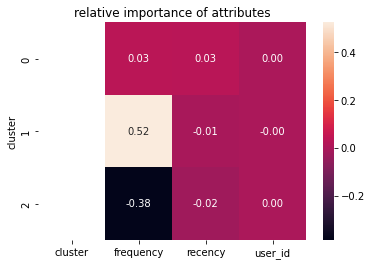

In [46]:
sns.heatmap(data=relative_importance,annot=True,fmt='.2f')
plt.title('relative importance of attributes')